Используя шаблон ноутбука, напишите загрузку данных и распознавание стилей музыки с помощью Dense сети. 

Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками

# Импорт библиотек

In [ ]:
from google.colab import files, drive
from tensorflow.keras.utils import to_categorical
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Подключение к Диску и импорт данных

In [ ]:
drive.mount('/content/drive')
!unzip -q '/content/drive/MyDrive/Lessons/Lesson8/genres.zip'
genres = os.listdir('genres')
!ls genres 
!ls genres/blues

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blue

# Функции для работы с аудиозаписями

In [ ]:
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  rmse = np.mean(librosa.feature.rms(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))
  
  return out

 # Подготовка данных для обучения

In [ ]:
import time

X_train = []
Y_train = []

curr_time = time.time()

for i in range(len(genres)):
  g = genres[i]
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))

  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр reggae готов -> 45c
Жанр classical готов -> 48c
Жанр pop готов -> 43c
Жанр country готов -> 44c
Жанр metal готов -> 43c
Жанр rock готов -> 44c
Жанр disco готов -> 44c
Жанр blues готов -> 43c
Жанр hiphop готов -> 43c
Жанр jazz готов -> 45c


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


## Стандартизация

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
print(X_train[0])

[-0.6143136  -0.62558909 -0.4114107  -0.51006495 -0.71091224 -0.47670988
  0.54161429 -0.09331444 -0.38362649  0.0403447   0.57340795 -0.68161325
  0.81368626 -0.73490208  0.84803437 -0.20026022  0.05368319  0.32168757
  0.26642063  0.46144932 -0.77293625 -0.56070254 -0.49565435 -0.8549368
 -0.38078171  0.25149268  0.00164557  0.68194754  0.3761638  -0.2863961
  0.90566014 -0.11265239 -0.77992947 -0.77952004 -0.41515986  0.9199236
  0.05637897]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


# Подготовка и обучение модели

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/200
45/45 [==============================] - 1s 7ms/step - loss: 2.0562 - accuracy: 0.2411 - val_loss: 1.8062 - val_accuracy: 0.3300
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.7066 - accuracy: 0.3811 - val_loss: 1.6296 - val_accuracy: 0.3400
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5528 - accuracy: 0.4633 - val_loss: 1.5251 - val_accuracy: 0.4500
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4508 - accuracy: 0.5067 - val_loss: 1.4459 - val_accuracy: 0.5200
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3752 - accuracy: 0.5344 - val_loss: 1.3983 - val_accuracy: 0.5100
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3128 - accuracy: 0.5678 - val_loss: 1.3453 - val_accuracy: 0.5600
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2602 - accuracy: 0.5900 - val_loss: 1.3081 - val_accuracy: 0.5600
Epoch 8/200
4

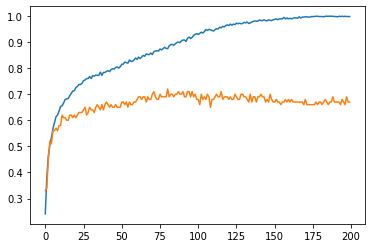

In [ ]:
indexes = range(0,37)

model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()